# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4565.dev0+gc0fae98
2.9.0


In [2]:
# if save the data to CSV
save_data = True
file_beging = 'cosim_'
sim_name = 'ieee39_s'

# case parameters
case_name = 'ieee39'
caseH = 18  # start time [H] of the co-simulation
ict = False
ecc = False
agc = False

# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 0.0, 0.0, 0.05

In [3]:
%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.


Generating code for 1 models on 6 processes.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


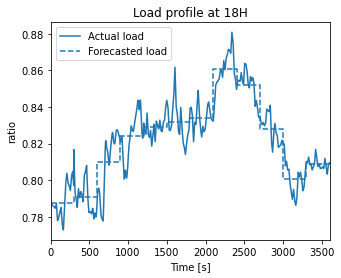

In [4]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [5]:
%run -i 'cosim_setup_dispatch.py'

Restricted license - for non-production use only - expires 2023-10-25


RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

Loop

In [6]:
%run -i 'cosim_main.py'

  0%|                                                                                                 | 0/3600 [00:00<?, ?it/s]RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4660.003
  8%|███████▎                                                                               | 300/3600 [01:00<10:10,  5.41it/s]RTED GB model is loaded.
RTED is solved.
RTED: total cost=4661.806
 17%|██████████████▌                                                                        | 600/3600 [02:06<11:15,  4.44it/s]RTED GB model is loaded.
RTED is solved.
RTED: total cost=4684.579
 25%|█████████████████████▊                                                                 | 900/3600 [03:20<11:03,  4.07it/s]RTED GB model is loaded.
RTED is solved.
RTED: total cost=4701.647
 33%|████████████████████████████▋                                                         | 1200/3600 [04:43<11:30,  3.48it/s]RTED GB model is loaded.
RTED is solved.
RTED: total cost=4707.3

In [7]:
ssa.exit_code

0

(<Figure size 4800x2000 with 1 Axes>,
 <AxesSubplot: title={'center': 'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

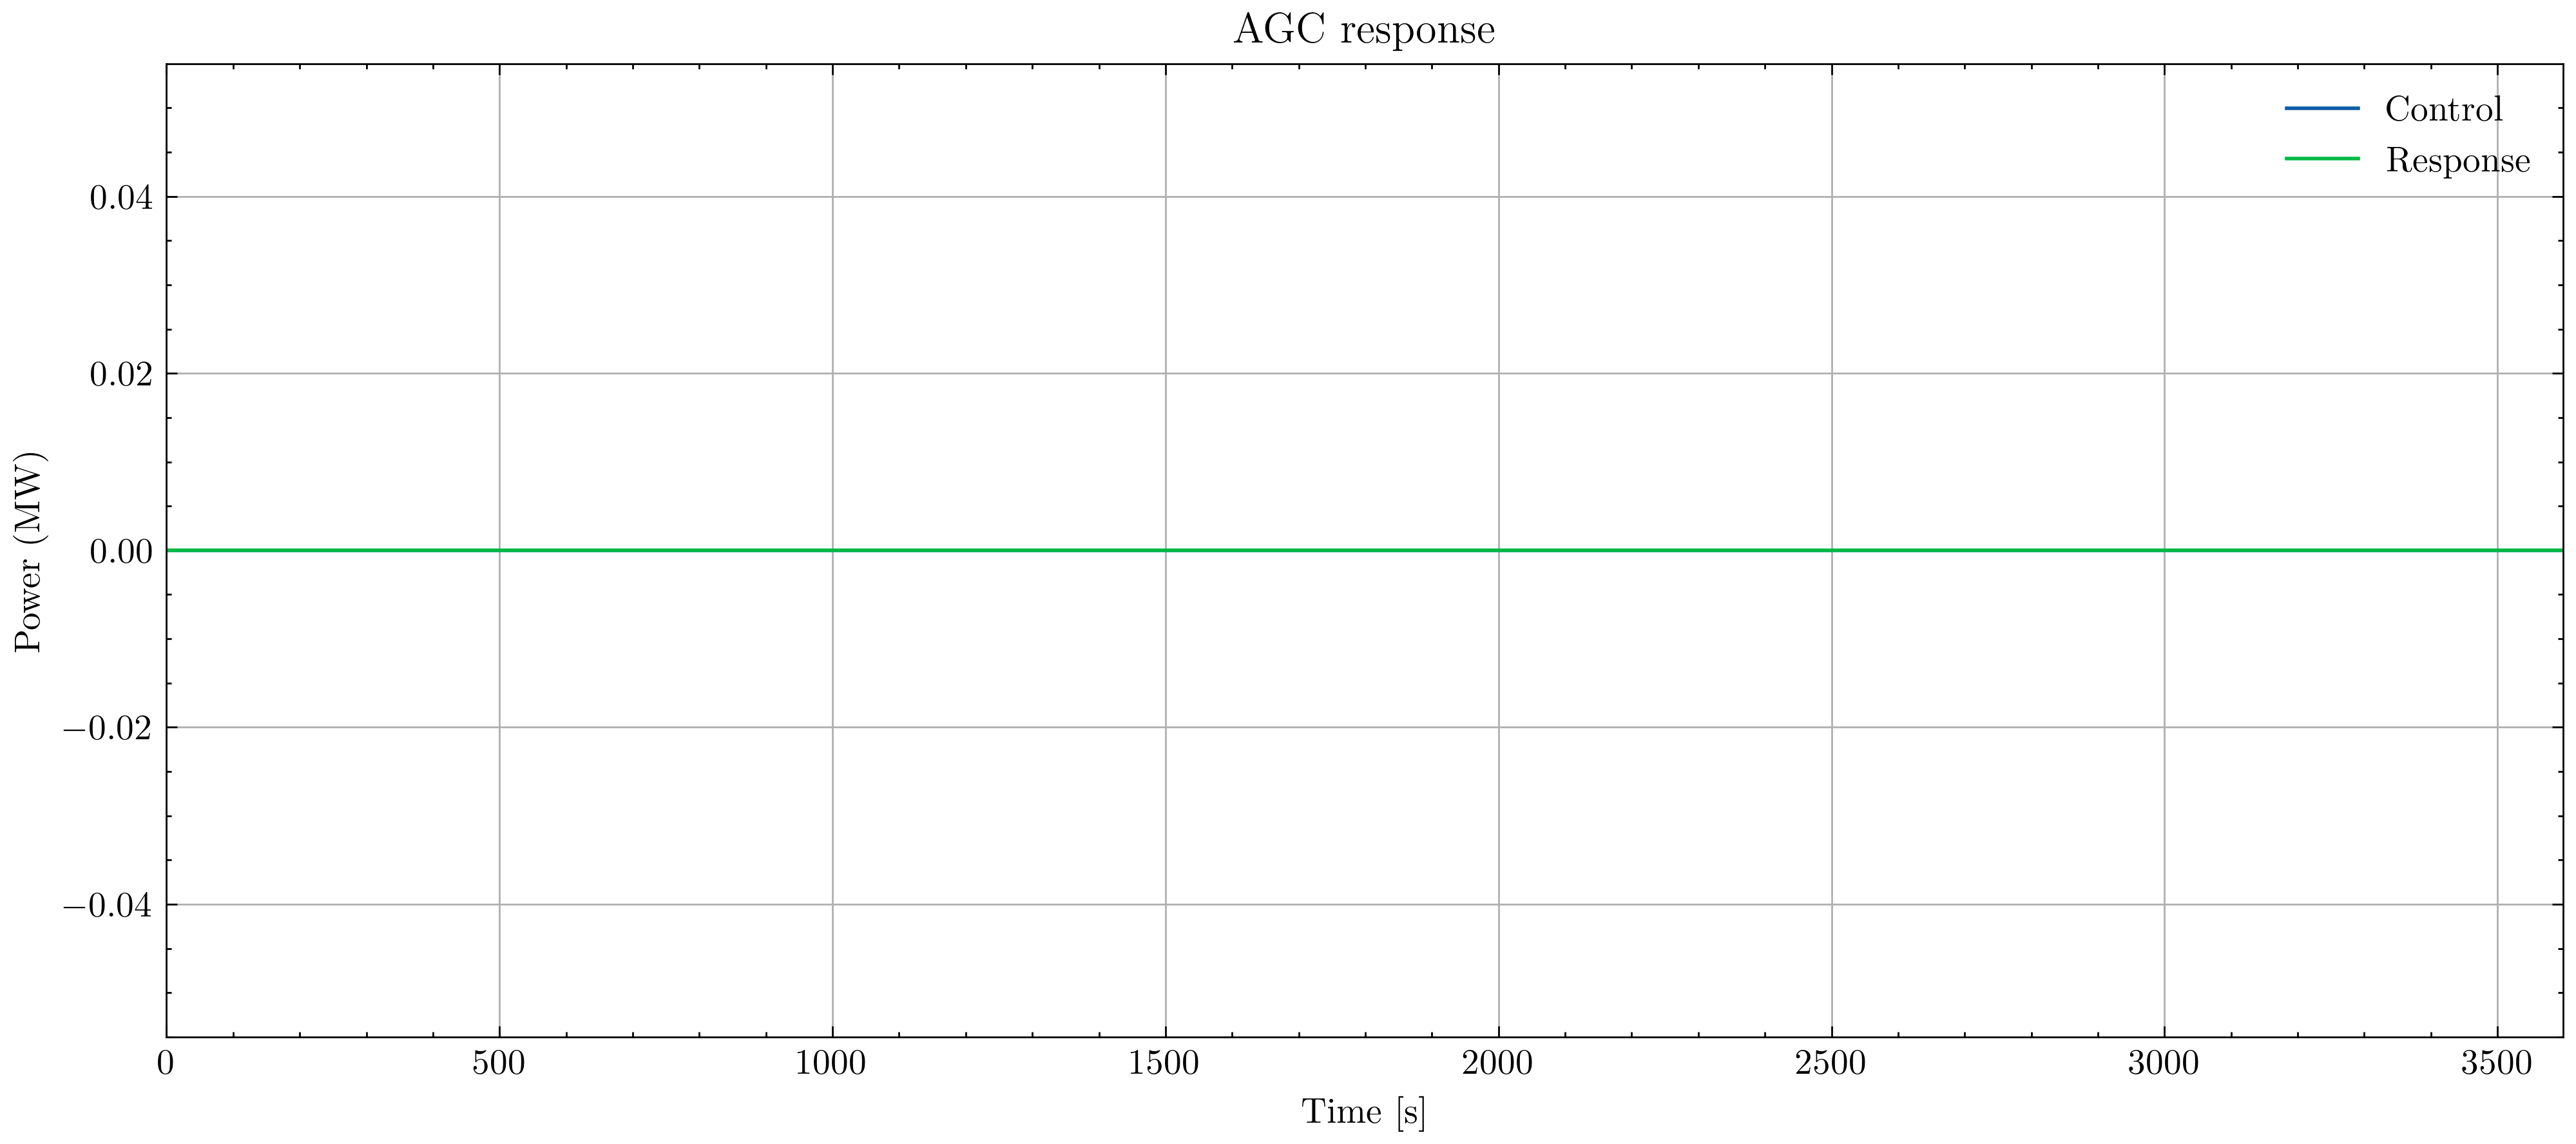

In [8]:
sse.ict()
sse.plot_agc(figsize=(12, 5), style='science', dpi=400)

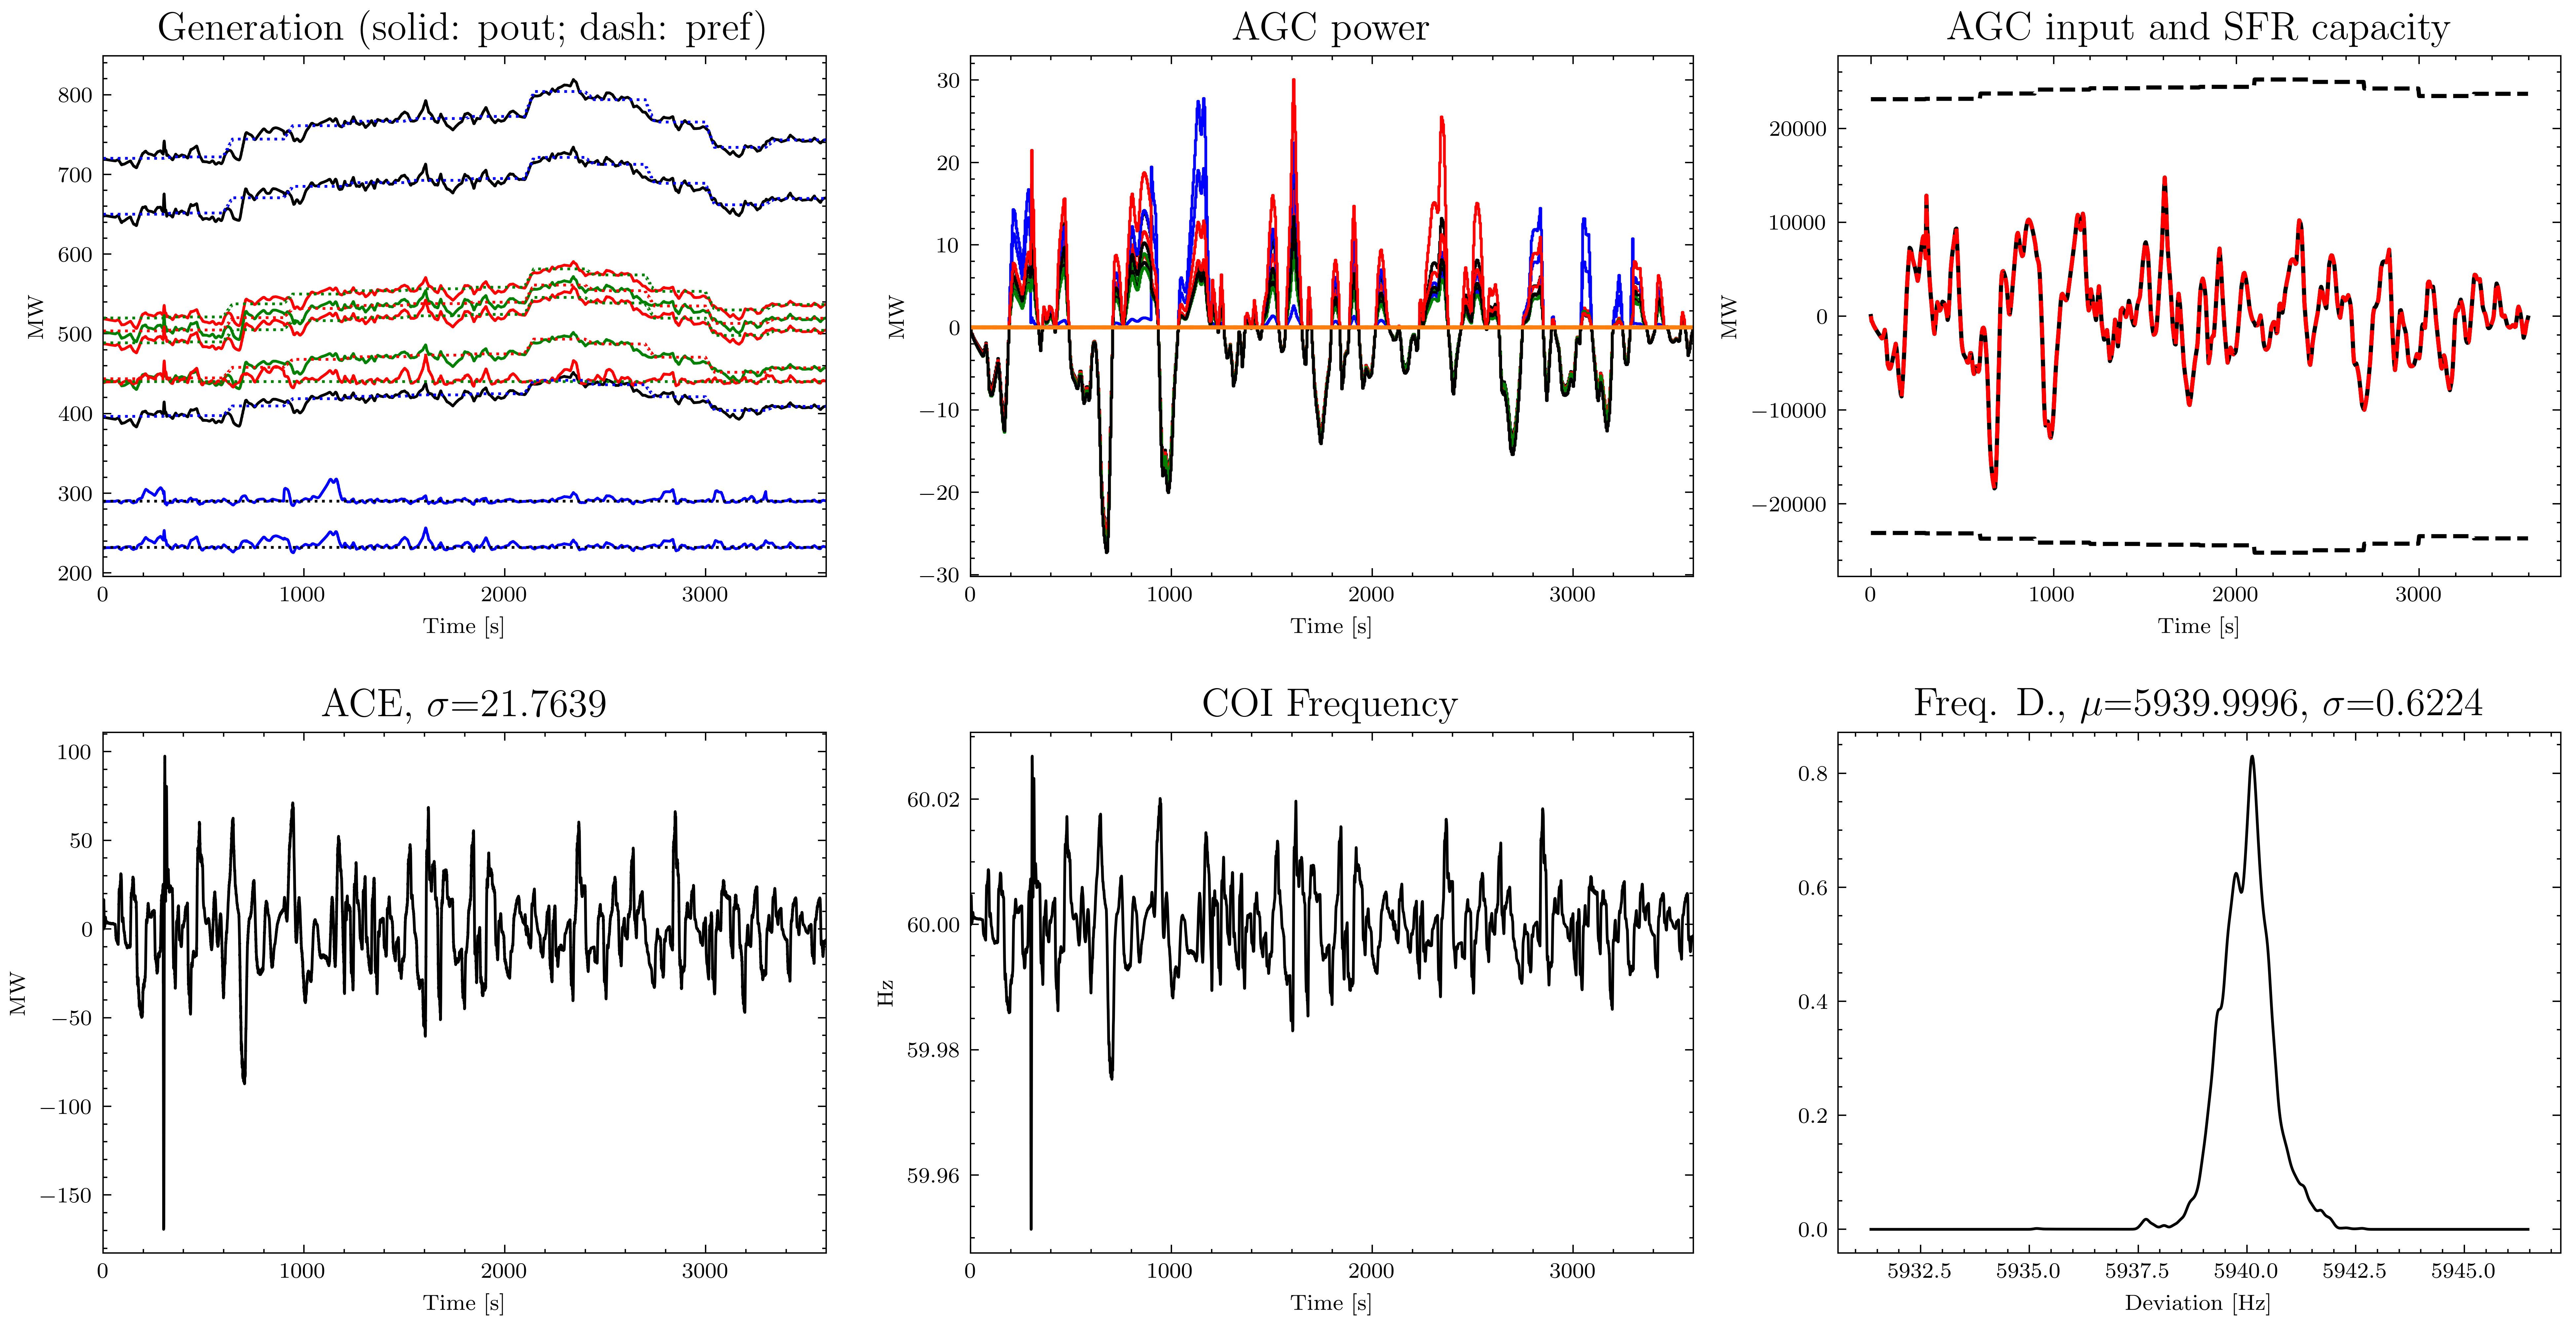

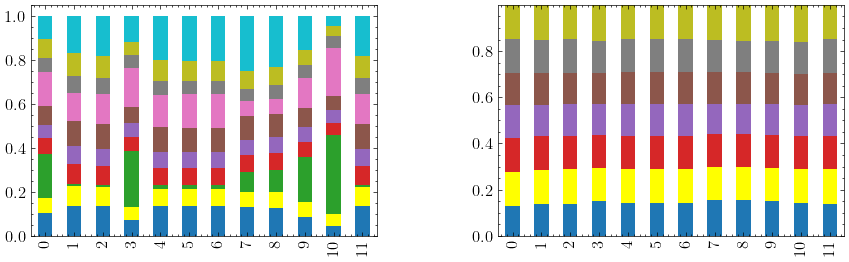

In [9]:
%run -i 'cosim_plot.py'

In [10]:
%run -i 'cosim_savedata.py'

Successfully save data.
